In [9]:
import pandas as pd
import numpy as np

# Load the Batting and Fielding data
batting = pd.read_csv("/Users/lizvitai/Documents/Pythonsports/Batting.csv")
fielding = pd.read_csv("/Users/lizvitai/Documents/Pythonsports/Fielding.csv")

# Exclude pitchers using the Fielding data
positional_players = fielding[fielding['POS'] != 'P']
positional_player_ids = positional_players['playerID'].unique()
batting = batting[batting['playerID'].isin(positional_player_ids)]

# Filter players from the 2010s
batting['yearID'] = batting['yearID'].astype(int)  # Ensure yearID is integer for comparison
is_2010s = np.in1d(batting['yearID'], range(2010, 2021))  # Filter for 2010 to 2020
batting_2010s = batting[is_2010s]

# Exclude rows with missing or zero AB
batting_2010s = batting_2010s[batting_2010s['AB'] > 0]

# Aggregate stats by player ID
aggregated = batting_2010s.groupby('playerID').agg({
    'H': 'sum',
    '2B': 'sum',
    '3B': 'sum',
    'HR': 'sum',
    'AB': 'sum',
    'BB': 'sum',
    'HBP': 'sum',
    'SF': 'sum'
}).reset_index()

# Calculate additional metrics
aggregated['BA'] = aggregated['H'] / aggregated['AB']  # Batting Average
aggregated['1B'] = aggregated['H'] - (aggregated['2B'] + aggregated['3B'] + aggregated['HR'])  # Singles (1B)

# Calculate Slugging Percentage (SLG)
aggregated['SLG'] = (aggregated['1B'] + 2 * aggregated['2B'] + 3 * aggregated['3B'] + 4 * aggregated['HR']) / aggregated['AB']

# Calculate On-Base Percentage (OBP)
aggregated['OBP'] = (aggregated['H'] + aggregated['BB'] + aggregated['HBP']) / (aggregated['AB'] + aggregated['BB'] + aggregated['HBP'] + aggregated['SF'])

# Rank players for each metric
aggregated['HR_rank'] = aggregated['HR'].rank(ascending=False, method='min')
aggregated['H_rank'] = aggregated['H'].rank(ascending=False, method='min')
aggregated['BA_rank'] = aggregated['BA'].rank(ascending=False, method='min')
aggregated['SLG_rank'] = aggregated['SLG'].rank(ascending=False, method='min')
aggregated['OBP_rank'] = aggregated['OBP'].rank(ascending=False, method='min')

# Summing the rankings for each player (Borda count)
aggregated['overall_rank'] = (aggregated['HR_rank'] + aggregated['H_rank'] + aggregated['BA_rank'] +
                              aggregated['SLG_rank'] + aggregated['OBP_rank'])

# Rank the overall rankings (no ties)
aggregated['Borda_rank'] = aggregated['overall_rank'].rank(ascending=True, method='min')

# Filter players with at least 50 At-Bats
filtered_50_ab = aggregated[aggregated['AB'] >= 50]

# Sort the players by overall Borda ranking for ≥50 AB
batting_sorted_50 = filtered_50_ab[['playerID', 'HR_rank', 'H_rank', 'BA_rank', 'SLG_rank', 'OBP_rank', 'overall_rank', 'Borda_rank']]
batting_sorted_50 = batting_sorted_50.sort_values(by='Borda_rank')

# Display the top players based on overall Borda ranking for ≥50 AB
print("\nTop Players with ≥50 At-Bats in the 2010s, Sorted by Borda Rank:")
print(batting_sorted_50.head(25))

# Filter players with at least 1000 At-Bats
filtered_1000_ab = aggregated[aggregated['AB'] >= 1000]

# Sort the players by overall Borda ranking for ≥1000 AB
batting_sorted_1000 = filtered_1000_ab[['playerID', 'HR_rank', 'H_rank', 'BA_rank', 'SLG_rank', 'OBP_rank', 'overall_rank', 'Borda_rank']]
batting_sorted_1000 = batting_sorted_1000.sort_values(by='Borda_rank')

# Display the top players based on overall Borda ranking for ≥1000 AB
print("\nTop Players with ≥1000 At-Bats in the 2010s, Sorted by Borda Rank:")
print(batting_sorted_1000.head(25))



Top Players with ≥50 At-Bats in the 2010s, Sorted by Borda Rank:
       playerID  HR_rank  H_rank  BA_rank  SLG_rank  OBP_rank  overall_rank  \
216   cabremi01      7.0     4.0     36.0      39.0      34.0         120.0   
1554  troutmi01      4.0    26.0     46.0      24.0      21.0         121.0   
1609  vottojo01     16.0     9.0     48.0      63.0      20.0         156.0   
564   goldspa01     12.0    23.0     74.0      52.0      36.0         197.0   
507   freemfr01     18.0    10.0     67.0      66.0      48.0         209.0   
117   beltrad01     25.0    14.0     42.0      62.0     117.0         260.0   
235    canoro01     14.0     1.0     53.0      98.0     110.0         276.0   
1125  ortizda01     28.0   100.0     78.0      27.0      47.0         280.0   
176   braunry02     12.0    18.0     79.0      59.0     123.0         291.0   
139   blackch02     45.0    38.0     47.0      75.0     107.0         312.0   
132   bettsmo01     68.0    94.0     52.0      53.0      70.0    


Correlation Matrix for the 5 Metrics:
           HR_rank    H_rank   BA_rank  SLG_rank  OBP_rank
HR_rank   1.000000  0.931009  0.532898  0.735061  0.569032
H_rank    0.931009  1.000000  0.617177  0.607100  0.592377
BA_rank   0.532898  0.617177  1.000000  0.721782  0.807867
SLG_rank  0.735061  0.607100  0.721782  1.000000  0.709413
OBP_rank  0.569032  0.592377  0.807867  0.709413  1.000000


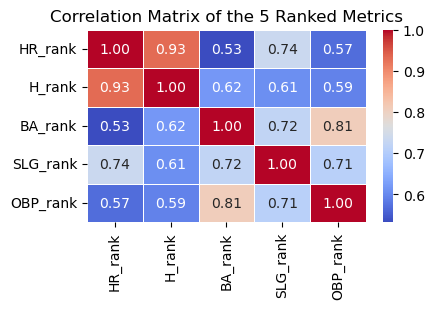

In [10]:
# Select the relevant columns for the 5 metrics
metrics = aggregated[['HR_rank', 'H_rank', 'BA_rank', 'SLG_rank', 'OBP_rank']]

# Calculate the correlation matrix for the 5 metrics
correlation_matrix = metrics.corr()

# Display the correlation matrix
print("\nCorrelation Matrix for the 5 Metrics:")
print(correlation_matrix)

# Graph correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4.5, 2.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of the 5 Ranked Metrics')
plt.show()
